In [20]:
# https://mygeoblog.com/2019/06/25/mask-netcdf-using-shp-file/

import netCDF4
import numpy as np
import pandas as pd
from osgeo import gdal,osr,ogr
import matplotlib.pyplot as plt

In [21]:
# set the data directories
shapefile = "D:\\A1_JM\\areas\\previous_areas\\manacapuru.shp"
ncs = "D:\\git-repos\\cams_visu\\cams_visu\\test_dl\\cams_2019.nc"

In [106]:
# function to create the mask of your shapefile
def makeMask(shp,lon,lat,res):
    source_ds = ogr.Open(shp)
    source_layer = source_ds.GetLayer()
 
    # Create high res raster in memory
    mem_ds = gdal.GetDriverByName('MEM').Create('', lon.size, lat.size, gdal.GDT_Byte)
    mem_ds.SetGeoTransform((lon.min(), res, 0, lat.max(), 0, -res))
    band = mem_ds.GetRasterBand(1)
 
    # Rasterize shapefile to grid
    gdal.RasterizeLayer(mem_ds, [1], source_layer, burn_values=[1])
 
    # Get rasterized shapefile as numpy array
    array = band.ReadAsArray()
 
    # Flush memory file
    mem_ds = None
    band = None
    return array

In [22]:
# read the netcdf data file
nc = netCDF4.Dataset(ncs,'r')
nc

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2020-12-04 08:39:43 GMT by grib_to_netcdf-2.19.0: grib_to_netcdf /data/scratch/20201204-0830/a5/_mars-webmars-public-svc-blue-007-6fe5cac1a363ec1525f54343b6cc9fd8-o638uy.grib -o /data/scratch/20201204-0830/54/_grib2netcdf-webmars-public-svc-blue-001-6fe5cac1a363ec1525f54343b6cc9fd8-X8bMGB.nc -utime
    dimensions(sizes): longitude(305), latitude(249), time(1460)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 tcno2(time,latitude,longitude), int16 tcwv(time,latitude,longitude), int16 msl(time,latitude,longitude), int16 u10(time,latitude,longitude), int16 v10(time,latitude,longitude), int16 t2m(time,latitude,longitude), int16 tco3(time,latitude,longitude), int16 aod550(time,latitude,longitude), int16 aod469(time,latitude,longitude), int16 aod670(time,latitude,longitude), int16 aod865(time,la

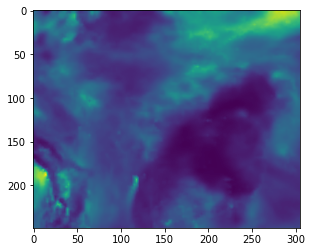

In [99]:
# get the total Aerosol Optical Depth at 865nm 
aod = nc.variables['aod865'][120][:]
 
# show the AOD
plt.imshow(aod)
plt.show()

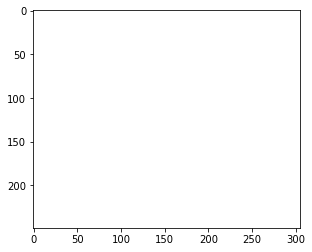

In [110]:
# get the longitude information
lons = nc.variables['longitude'][:]
# get the latitude information
lats = nc.variables['latitude'][:]

# extract the time dimension
# https://stackoverflow.com/questions/37854256/how-to-read-date-and-time-on-ecmwf-file
# time = netCDF4.num2date(time[:], time.units, time.calendar)
time = nc.variables['time'][:]

# calculate the cellsize
cellsize = lons[:][1] - lons[:][0]

# create the mask
mask = makeMask(shapefile,lons,lats,cellsize)
 
# mask the precipitation data
aod_msk = np.ma.masked_where(mask==0,aod)
 
plt.imshow(aod_msk)
plt.show()
 
# print some stats
# print(np.min(aod_msk), np.mean(aod_msk), np.max(aod_msk))

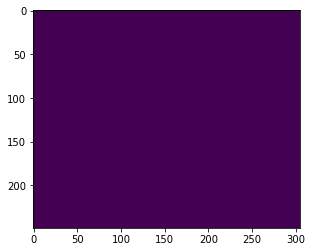

In [105]:
# show the mask
plt.imshow(mask)
plt.show()

## NetCDF4 Date Operations

In [55]:
time[0].__str__()

cftime.DatetimeGregorian(2019-01-01 00:00:00)

In [83]:
time_num = nc.variables['time'][:]
type(time_num)

numpy.ma.core.MaskedArray

In [64]:
def nc_dt2num(date):
    # https://stackoverflow.com/questions/39997314/write-times-in-netcdf-file
    units = "hours since 1900-01-01 00:00:00.0"
    calendar = "gregorian"
    return netCDF4.date2num(date, units=units, calendar=calendar)

In [69]:
nc_dt2num(time[0])

1043136.0

In [66]:
# Sentinel-3
madeiraxls = 'D:\\processing\\win\\MADEIRAv9b.xlsx'
df_s3 = pd.read_excel(madeiraxls,sheet_name='MADEIRAv9b')

# removes hour:minute:seconds from Sentinel-3 data.
df_s3['Date'] = [e.replace(hour=0, minute=0, second=0) for e in df_s3['Datetime']]

# Sort the data by increasing date
df_s3_srtd = df_s3.sort_values(by='Date')

# Get S3 data matching CAMS year 2019
s3_2019 = df_s3_srtd[df_s3_srtd['Date'].dt.year == 2019].copy()

In [62]:
s3_2019[['Date','T865']][0:5]

,Date,T865
86,2019-01-31,0.003780
87,2019-03-14,0.301933
88,2019-03-18,0.294775
89,2019-03-20,0.228399
90,2019-03-28,0.168255


In [63]:
# Create a new column to match the days from S3 and CAMS in numeric format

In [78]:
s3_2019['dt2num'] = [int(nc_dt2num(d)) for d in s3_2019['Date']]

In [79]:
s3_2019[['Date','dt2num']][0:5]

,Date,dt2num
0,2019-01-31,1043856
1,2019-03-14,1044864
2,2019-03-18,1044960
3,2019-03-20,1045008
4,2019-03-28,1045200


In [80]:
s3_2019.reset_index(drop=True, inplace=True)

In [81]:
type(s3_2019['dt2num'][0])

numpy.int64

In [84]:
match_list = np.delete(time_num, s3_2019['dt2num'])

C:\Users\david\.conda\envs\git-prj\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  """Entry point for launching an IPython kernel.


In [98]:
np.where(time_num == s3_2019['dt2num'][0])

(array([120], dtype=int64),)

## RASTERIO and XARRAY

In [9]:
import geopandas as gpd
import shapely
import xarray
import rasterio
import glob

In [112]:
xr_cams = xarray.open_dataset(ncs)

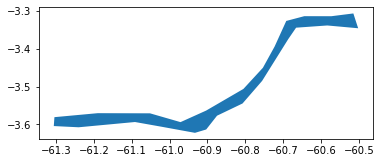

In [10]:
geom = []

# Reading SHP with geopandas
ROI = gpd.read_file(shapefile)
ROI.plot()

# Extracting 
coord = shapely.geometry.mapping(ROI)["features"][0]["geometry"]
geom.append(coord)

In [11]:
geom

[{'type': 'Polygon',
  'coordinates': (((-61.30429293775388, -3.580746157823998, 0.0),
    (-61.1897384822911, -3.570230611586103, 0.0),
    (-61.05179603816328, -3.570623959031377, 0.0),
    (-60.97117502053865, -3.593840244684938, 0.0),
    (-60.9034262153111, -3.563360680269377, 0.0),
    (-60.8050207829191, -3.506299406583337, 0.0),
    (-60.75351909462714, -3.450505864090518, 0.0),
    (-60.72245698492745, -3.39425947814228, 0.0),
    (-60.69176635463603, -3.326974300372498, 0.0),
    (-60.64421466170581, -3.314434177206381, 0.0),
    (-60.57262505187506, -3.314523058454226, 0.0),
    (-60.51454131805458, -3.307213505528399, 0.0),
    (-60.50184936718516, -3.346258308422025, 0.0),
    (-60.58341863239737, -3.33894030325553, 0.0),
    (-60.66584003065841, -3.344760708787252, 0.0),
    (-60.68655867873147, -3.374889635076542, 0.0),
    (-60.75565447035964, -3.48512230522507, 0.0),
    (-60.8073072779367, -3.544639712461309, 0.0),
    (-60.87472835451074, -3.576891855197255, 0.0),
  

## Making a mask with RIOXARRAY

In [1]:
# https://gis.stackexchange.com/questions/354782/how-to-mask-netcdf-time-series-data-from-a-shapefile-in-python/354798#354798
# https://github.com/corteva/rioxarray
# https://corteva.github.io/rioxarray/stable/examples/clip_geom.html

In [5]:
import geopandas
import rioxarray
import xarray
from shapely.geometry import mapping

xrio_cams = xarray.open_dataarray(ncs)
xrio_cams.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
xrio_cams.rio.write_crs("epsg:4326", inplace=True)
manaca_shp = geopandas.read_file(shapefile, crs="epsg:4326")

# clipped = xrio_cams.rio.clip(manaca_shp.geometry.apply(mapping), manaca_shp.crs, drop=False)

ValueError: Given file dataset contains more than one data variable. Please read with xarray.open_dataset and then select the variable you want.

In [6]:
xds = rioxarray.open_rasterio(ncs, masked=True, chunks=True)

In [7]:
xds

<xarray.Dataset>
Dimensions:      (time: 1460, x: 305, y: 249)
Coordinates:
  * y            (y) float64 5.0 4.875 4.75 4.625 ... -25.62 -25.75 -25.88 -26.0
  * x            (x) float64 -72.0 -71.88 -71.75 -71.62 ... -34.25 -34.12 -34.0
  * time         (time) object 2019-01-01 00:00:00 ... 2019-12-31 18:00:00
    spatial_ref  int32 0
Data variables:
    tcno2        (time, y, x) float64 dask.array<chunksize=(1, 249, 305), meta=np.ndarray>
    aod670       (time, y, x) float64 dask.array<chunksize=(1, 249, 305), meta=np.ndarray>
    aod865       (time, y, x) float64 dask.array<chunksize=(1, 249, 305), meta=np.ndarray>
    aod1240      (time, y, x) float64 dask.array<chunksize=(1, 249, 305), meta=np.ndarray>
    siconc       (time, y, x) float64 dask.array<chunksize=(1, 249, 305), meta=np.ndarray>
    sst          (time, y, x) float64 dask.array<chunksize=(1, 249, 305), meta=np.ndarray>
    tcwv         (time, y, x) float64 dask.array<chunksize=(1, 249, 305), meta=np.ndarray>
    msl          (time, y, x) float64 dask.array<chunksize=(1, 249, 305), meta=np.ndarray>
    u10          (time, y, x) float64 dask.array<chunksize=(1, 249, 305), meta=np.ndarray>
    v10          (time, y, x) float64 dask.array<chunksize=(1, 249, 305), meta=np.ndarray>
    t2m          (time, y, x) float64 dask.array<chunksize=(1, 249, 305), meta=np.ndarray>
    tco3         (time, y, x) float64 dask.array<chunksize=(1, 249, 305), meta=np.ndarray>
    aod550       (time, y, x) float64 dask.array<chunksize=(1, 249, 305), meta=np.ndarray>
    aod469       (time, y, x) float64 dask.array<chunksize=(1, 249, 305), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-12-04 08:39:43 GMT by grib_to_netcdf-2.19.0: grib_to_n...

In [13]:
xds.rio.write_crs("epsg:4326", inplace=True)

<xarray.Dataset>
Dimensions:      (time: 1460, x: 305, y: 249)
Coordinates:
  * y            (y) float64 5.0 4.875 4.75 4.625 ... -25.62 -25.75 -25.88 -26.0
  * x            (x) float64 -72.0 -71.88 -71.75 -71.62 ... -34.25 -34.12 -34.0
  * time         (time) object 2019-01-01 00:00:00 ... 2019-12-31 18:00:00
    spatial_ref  int32 0
Data variables:
    tcno2        (time, y, x) float64 dask.array<chunksize=(1, 249, 305), meta=np.ndarray>
    aod670       (time, y, x) float64 dask.array<chunksize=(1, 249, 305), meta=np.ndarray>
    aod865       (time, y, x) float64 dask.array<chunksize=(1, 249, 305), meta=np.ndarray>
    aod1240      (time, y, x) float64 dask.array<chunksize=(1, 249, 305), meta=np.ndarray>
    siconc       (time, y, x) float64 dask.array<chunksize=(1, 249, 305), meta=np.ndarray>
    sst          (time, y, x) float64 dask.array<chunksize=(1, 249, 305), meta=np.ndarray>
    tcwv         (time, y, x) float64 dask.array<chunksize=(1, 249, 305), meta=np.ndarray>
    msl          (time, y, x) float64 dask.array<chunksize=(1, 249, 305), meta=np.ndarray>
    u10          (time, y, x) float64 dask.array<chunksize=(1, 249, 305), meta=np.ndarray>
    v10          (time, y, x) float64 dask.array<chunksize=(1, 249, 305), meta=np.ndarray>
    t2m          (time, y, x) float64 dask.array<chunksize=(1, 249, 305), meta=np.ndarray>
    tco3         (time, y, x) float64 dask.array<chunksize=(1, 249, 305), meta=np.ndarray>
    aod550       (time, y, x) float64 dask.array<chunksize=(1, 249, 305), meta=np.ndarray>
    aod469       (time, y, x) float64 dask.array<chunksize=(1, 249, 305), meta=np.ndarray>
Attributes:
    Conventions:   CF-1.6
    history:       2020-12-04 08:39:43 GMT by grib_to_netcdf-2.19.0: grib_to_...
    grid_mapping:  spatial_ref

In [15]:
clipped = xds.rio.clip(geom)

NoDataInBounds: No data found in bounds. Data variable: tcno2

In [17]:
# https://gis.stackexchange.com/questions/289775/masking-netcdf-data-using-shapefile-xarray-geopandas
shp_geodf = geopandas.read_file(shapefile)
cams_xds = rioxarray.open_rasterio(ncs)
cams_xds.rio.write_crs("epsg:4326", inplace=True)
clipped = cams_xds.rio.clip(shp_geodf.geometry.apply(mapping), shp_geodf.crs)

NoDataInBounds: No data found in bounds. Data variable: tcno2

In [18]:
# https://salem.readthedocs.io/en/latest/xarray_acc.html#regions-of-interest